In [2]:
# Download data source and few other library if not already downloaded.

#!wget -P ./../input/ https://www.kaggle.com/c/fake-news/data
#!wget -P ./../resource/glove/ http://nlp.stanford.edu/data/glove.6B.zip
#!unzip ./../resource/glove/glove.6B.zip -d ./../resource/glove/


In [3]:
### Import all library

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [ ]:
# Function to read data
def read_data(filename,**kwargs):
    raw_data=pd.read_csv(filename,**kwargs)
    return raw_data

In [ ]:
# Setup Directory Path

root_dir = str(Path().resolve().parent)
input_dir = root_dir+"/input/"
output_dir = root_dir+"/output/"
model_dir = root_dir+"/model/"
image_dir = 'images/'
print(root_dir)

---

## Data Understanding
Datasets: [Fake news](https://www.kaggle.com/c/fake-news/data)
We will read here understand their charchteristics.

In [3]:
#### READ DATASTS

news_df= read_data("../input/train.csv")
submit_test = read_data('../input/test.csv')
submit_label = read_data('../input/submit.csv')
submit_test['label'] = submit_label.label
print(" Shape of News data :: ", news_df.shape)
print(" News data columns", news_df.columns)
print(" Test columns", submit_test.columns)
news_df.head()

 Shape of News data ::  (20800, 5)
 News data columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
 Test columns Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
submit_test.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


#### Note : There no label for test dataset., So we will use train set for training and validation after split.

In [5]:
# Text Word stats

text_len = news_df.text.str.split().str.len()
text_len.describe()

count    20761.000000
mean       760.308126
std        869.525988
min          0.000000
25%        269.000000
50%        556.000000
75%       1052.000000
max      24234.000000
Name: text, dtype: float64

In [6]:
# Title Stats 

title_len = news_df.title.str.split().str.len()
title_len.describe()

count    20242.000000
mean        12.420709
std          4.098735
min          1.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         72.000000
Name: title, dtype: float64

The statistic of Train and Test datasets are following: 
1. Attribute **text** having more words count with average of 760 words and 75% are less than 1000 word.
2. Attribute **title** are small sentence with average of 12 words and 75% are less than 15 only.

From following columns ['id', 'title', 'author', 'text', 'label'] we will not include id and author.

**Our experiment would be with both text and title together**

####  Count plot for both labels are


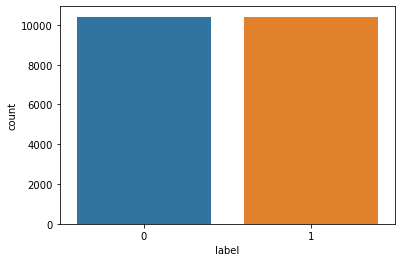

In [7]:
sns.countplot(x="label", data=news_df);
plt.show()

---

## Clean Datasets: 
   - Drop unused row and columns
   - Null value imputation
   - Remove special characters
   - Remove stop words

In [8]:
## Constants Used for cleaning the datasets

column_names = ['id', 'title', 'author', 'text', 'label']
remove_columns = ['id','author']
categorical_features = []
target_col = ['label']
text_features = ['title', 'text']


In [9]:
# Import necessary libraries and modules for data preprocessing
import nltk
from nltk.corpus import stopwords
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Initialize a Porter Stemmer and WordNet Lemmatizer
ps = PorterStemmer()
wnl = WordNetLemmatizer()

# Create a list of English stop words and convert it into a dictionary
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Define a function to remove unused columns from a DataFrame
def remove_unused_columns(df, column_names=remove_columns):
    df = df.drop(column_names, axis=1)
    return df

# Define a function to impute null values in text features with "None"
def null_processing(feature_df):
    for col in text_features:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

# Define a function to clean datasets by removing unused columns and imputing null values
def clean_datasets(df):
    df = remove_unused_columns(df)
    df = null_processing(df)
    return df

# Define a function to clean text by removing URLs, special characters, and extra spaces
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # Remove URLs
    text = str(text).replace(r'[^\.\w\s]', ' ')  # Remove special characters
    text = str(text).replace('[^a-zA-Z]', ' ')  # Remove non-alphabetic characters
    text = str(text).replace(r'\s\s+', ' ')  # Remove extra spaces
    text = text.lower().strip()  # Convert to lowercase and strip leading/trailing spaces
    return text

# Define a function for NLTK preprocessing (stop word removal)
def nltk_preprocessing(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return text

# Clean and preprocess the 'news_df' and 'submit_test' DataFrames
df = clean_datasets(news_df)
df_test = clean_datasets(submit_test)

# Apply NLTK preprocessing to the 'text' and 'title' columns in the DataFrames
df["text"] = df.text.apply(nltk_preprocessing)
df_test["text"] = df_test.text.apply(nltk_preprocessing)

df["title"] = df.title.apply(nltk_preprocessing)
df_test["title"] = df_test.title.apply(nltk_preprocessing)


In [10]:
df.head()

,title,text,label
0,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...,1
1,flynn hillary clinton big woman campus breitbart,ever get feeling life circle roundabout rather...,0
2,truth might get fired,truth might get fired october 29 2016 tension ...,1
3,15 civilian killed single u airstrike identified,video 15 civilian killed single u airstrike id...,1
4,iranian woman jailed fictional unpublished sto...,print iranian woman sentenced six year prison ...,1


---

## Explorative Data Analysis
- Univariate Analysis: Statistical Analysis of Text, Word cloud
- Bivariate Analysis : Bigram and Trigram


### Single word word cloud
Most frequent word appear with Bold and bigger font.
#### Word cloud for all word in datasets

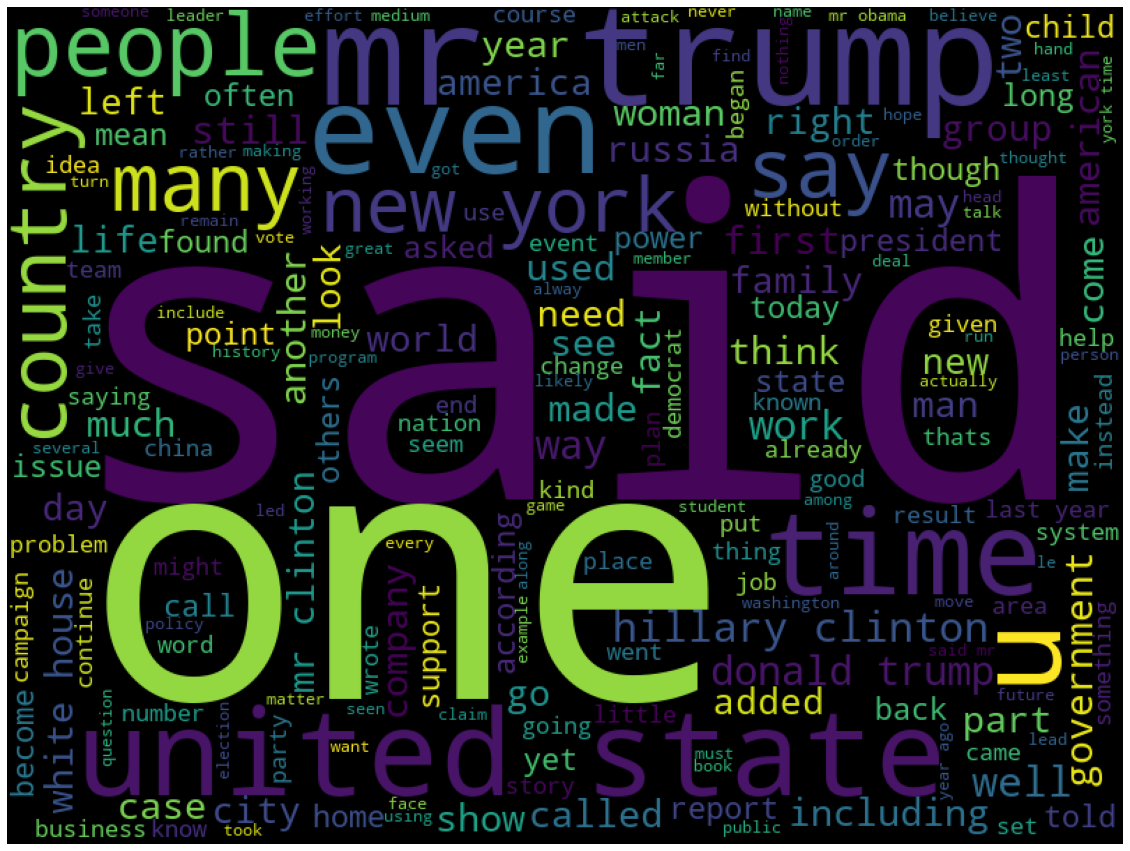

In [11]:
# Import necessary libraries for creating a word cloud and plotting
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Initialize a WordCloud object with specific background color and dimensions
wordcloud = WordCloud(background_color='black', width=800, height=600)

# Generate a word cloud from the 'text' column in the 'df' DataFrame
text_cloud = wordcloud.generate(' '.join(df['text']))

# Create a matplotlib figure with a specified size
plt.figure(figsize=(20, 30))

# Display the generated word cloud as an image
plt.imshow(text_cloud)

# Remove axis labels
plt.axis('off')

# Show the word cloud plot
plt.show()


### Word cloud for True label news only

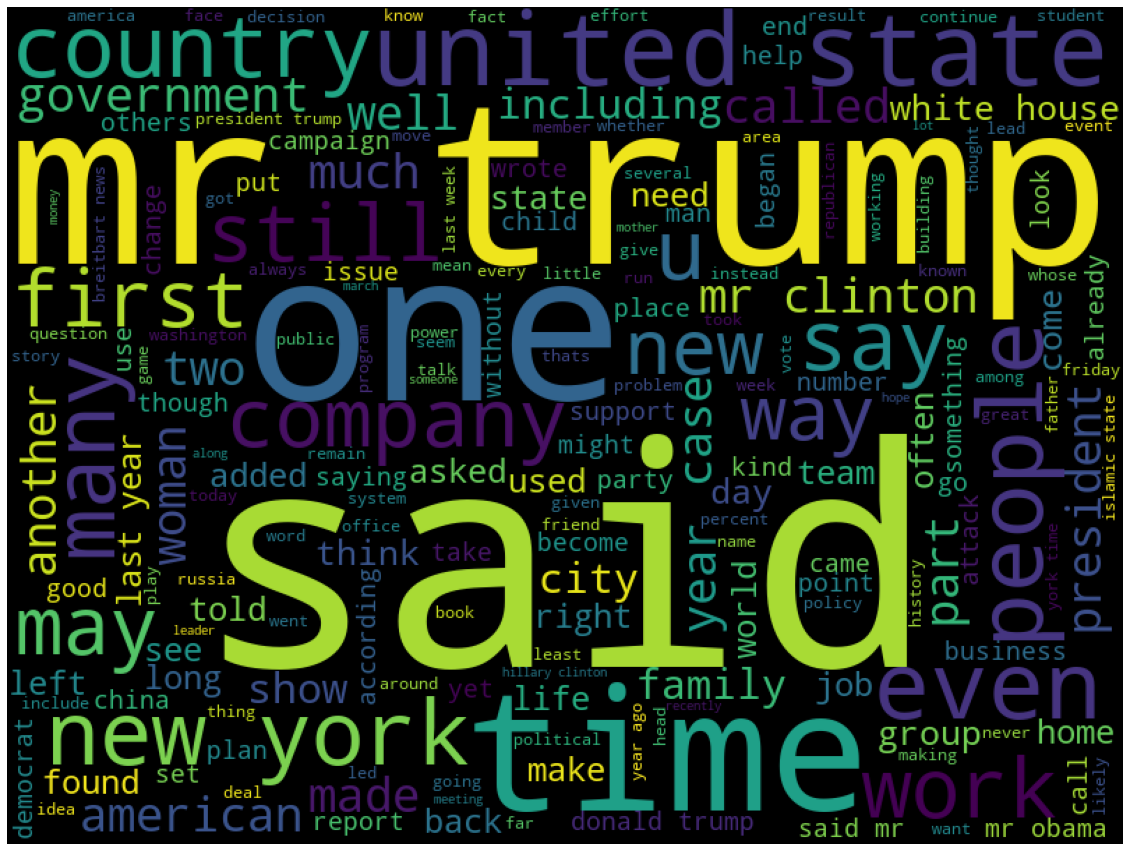

In [12]:
# Concatenate the 'text' data from rows where 'label' is equal to 0 (indicating true news)
true_news = ' '.join(df[df['label'] == 0]['text'])

# Generate a word cloud from the concatenated true news text
wc = wordcloud.generate(true_news)

# Create a matplotlib figure with a specified size
plt.figure(figsize=(20, 30))

# Display the generated word cloud as an image
plt.imshow(wc)

# Remove axis labels
plt.axis('off')

# Show the word cloud plot for true news
plt.show()


### Word cloud for Fake label news only

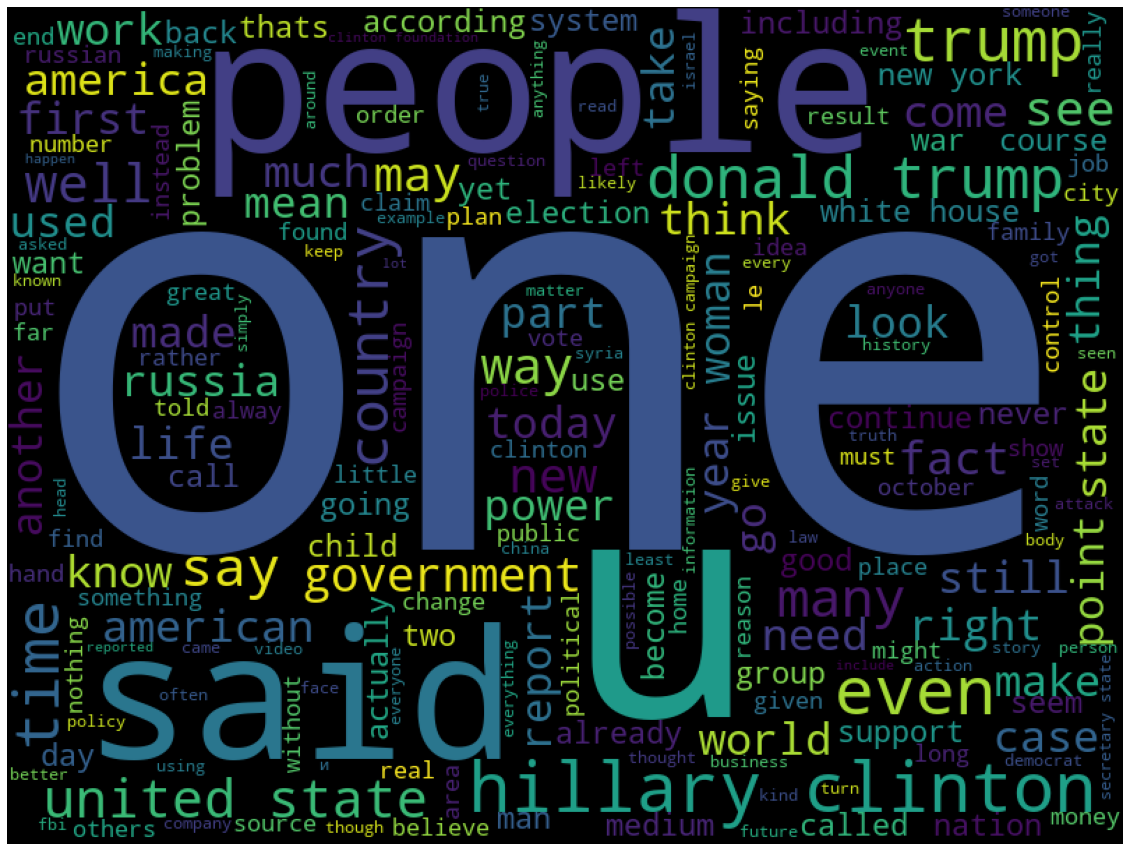

In [13]:
# Concatenate the 'text' data from rows where 'label' is equal to 1 (indicating fake news)
fake_news = ' '.join(df[df['label'] == 1]['text'])

# Generate a word cloud from the concatenated fake news text
wc = wordcloud.generate(fake_news)

# Create a matplotlib figure with a specified size
plt.figure(figsize=(20, 30))

# Display the generated word cloud as an image
plt.imshow(wc)

# Remove axis labels
plt.axis('off')

# Show the word cloud plot for fake news
plt.show()


---

# N-Gram

An n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. 


### Most frequent Bigram(Two word combination) of True label

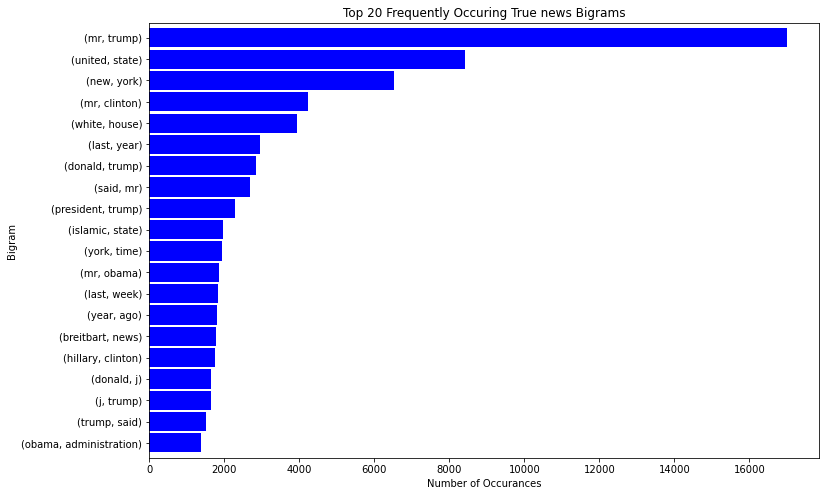

In [14]:
# Extract bigrams (pairs of consecutive words) from the 'true_news' text
true_bigrams = (pd.Series(nltk.ngrams(true_news.split(), 2)).value_counts())[:20]

# Sort the bigrams by their frequency and create a horizontal bar plot
true_bigrams.sort_values().plot.barh(color='blue', width=0.9, figsize=(12, 8))

# Set the plot title, y-axis label, and x-axis label
plt.title('Top 20 Frequently Occurring True News Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurrences')

# Show the bar plot of the top 20 frequently occurring true news bigrams
plt.show()


### Most frequent Bigram(Two word combination) of Fake label

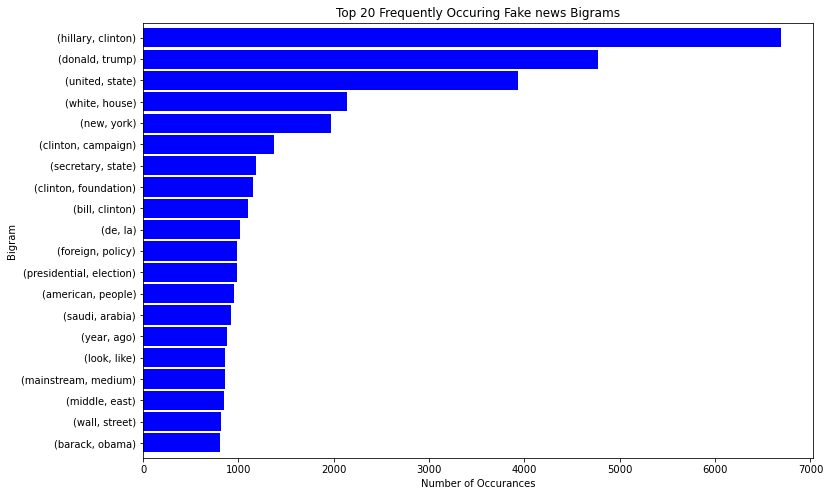

In [15]:
# Extract bigrams (pairs of consecutive words) from the 'fake_news' text
fake_bigrams = (pd.Series(nltk.ngrams(fake_news.split(), 2)).value counts())[:20]

# Sort the bigrams by their frequency and create a horizontal bar plot
fake_bigrams.sort_values().plot.barh(color='blue', width=0.9, figsize=(12, 8))

# Set the plot title, y-axis label, and x-axis label
plt.title('Top 20 Frequently Occurring Fake News Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurrences')

# Show the bar plot of the top 20 frequently occurring fake news bigrams
plt.show()


### Most frequent Trigram(Three word combination) of True label

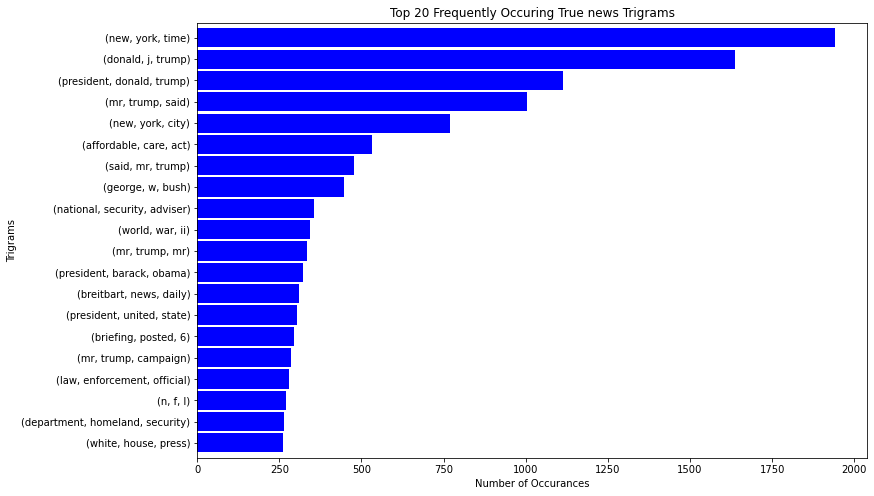

In [16]:
# Extract trigrams (consecutive sequences of three words) from the 'true_news' text
true_trigrams = (pd.Series(nltk.ngrams(true_news.split(), 3)).value_counts())[:20]

# Sort the trigrams by their frequency and create a horizontal bar plot
true_trigrams.sort_values().plot.barh(color='blue', width=0.9, figsize=(12, 8))

# Set the plot title, y-axis label, and x-axis label
plt.title('Top 20 Frequently Occurring True News Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurrences')

# Show the bar plot of the top 20 frequently occurring true news trigrams
plt.show()


### Most frequent Trigram(Three word combination) of Fake label

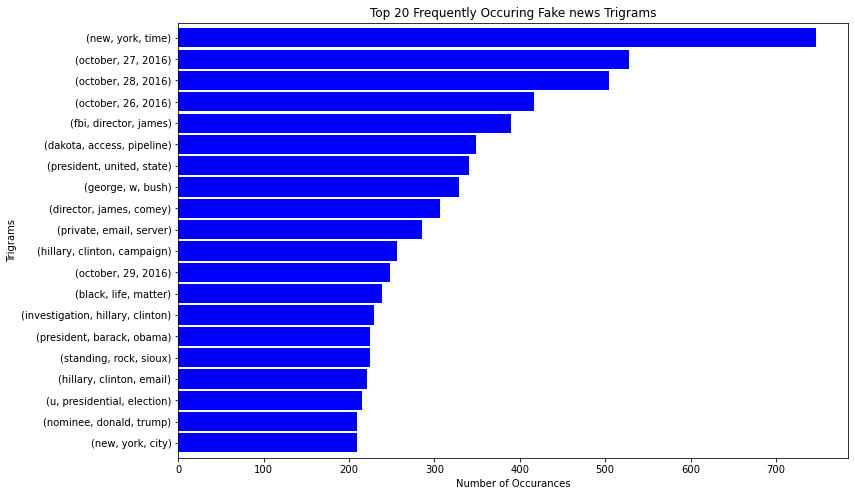

In [17]:
# Extract trigrams (consecutive sequences of three words) from the 'fake_news' text
fake_trigrams = (pd.Series(nltk.ngrams(fake_news.split(), 3)).value_counts())[:20]

# Sort the trigrams by their frequency and create a horizontal bar plot
fake_trigrams.sort_values().plot.barh(color='blue', width=0.9, figsize=(12, 8))

# Set the plot title, y-axis label, and x-axis label
plt.title('Top 20 Frequently Occurring Fake News Trigrams')
plt.ylabel('Trigrams')
plt.xlabel('Number of Occurrences')

# Show the bar plot of the top 20 frequently occurring fake news trigrams
plt.show()


#### Hence from Word cloud as well as Different N-gram word anaysis it is difficult to conclude anything. So we will include all words to train our model.

---

## Splitting training dataset into train and test for model selection and validation
   - Merge all Text Feature
   - Split datasets in Train, Test 


In [18]:
# Define a function to merge text features together and generate statistics on the merged text
def merge_text_features(df, text_features=text_features):
    # Concatenate the text features in the DataFrame into a single 'news' column
    df['news'] = df[text_features].agg(' '.join, axis=1)
    
    # Print statistics about the merged text, specifically the word count
    print("Merge news text statistics:\n", df.news.str.split().str.len().describe())
    
    return df

# Define a function for preparing datasets by merging text features and performing preprocessing
def preparing_datasets(df):
    # Merge text features together and obtain statistics
    XY = merge_text_features(df)
    
    # Optionally, additional cleaning steps could be applied here
    
    # Extract the 'news' column as the input data (X) and the 'label' column as the target (y)
    X = XY['news']
    y = XY.label
    
    # Print statistics about the merged and preprocessed text, specifically the word count
    print("Text length statistics after merging news and preprocessing:\n", X.str.split().str.len().describe())
    
    # If the target variable is of type 'object', it may need further processing (optional)
    if y.dtype == 'object':
        y = process_labels(y)  # Define the 'process_labels' function for label processing if needed
    
    return X, y


In [19]:
# Preprocessing datasets
print(" Training data preprocessing ")
X,y = preparing_datasets(df)

print(" Test data preprocessing ")
X_test,y_test = preparing_datasets(df_test)


 Training data preprocessing 
Merge news text statistics::
  count    20800.000000
mean       440.236490
std        490.971666
min          1.000000
25%        166.000000
50%        331.000000
75%        602.000000
max      20731.000000
Name: news, dtype: float64
 Cleaning as remove special character is done..
                                               title  \
0  house dem aide didnt even see comeys letter ja...   
1   flynn hillary clinton big woman campus breitbart   
2                              truth might get fired   
3   15 civilian killed single u airstrike identified   
4  iranian woman jailed fictional unpublished sto...   

                                                text  label  \
0  house dem aide didnt even see comeys letter ja...      1   
1  ever get feeling life circle roundabout rather...      0   
2  truth might get fired october 29 2016 tension ...      1   
3  video 15 civilian killed single u airstrike id...      1   
4  print iranian woman sentenced six

**There we can observe that mean number word for each news record is 471 and 75% quartile words length is 650 only. 
So based on this statistic, we can fix our word sequence using any suitable size for all news length as equal size.**

---

## Data Preperation

## Sequence Data Transformation :
   - Tokenization
   - Text sequence generation
   - Pad the text sequence data

### Text Tokenization
Keras tokenizer to convert each text into a sequence of words, and then create the vocabulary using method on the tokenizer.

In [20]:
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer

In [21]:
# Split the dataset into train and test sets with a test size of 20%
# Note: The actual split code is commented out and should be uncommented for use
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# For now, assign the entire dataset to the training set, as the test set is not defined
X_train, y_train = X, y

# Print the counts of the training and test data (test data is not defined here)
print("Train data counts:", X_train.shape)
print("Test data counts: Test data not defined")

# Define the out-of-vocabulary token for tokenization
oov_token = "<OOV>"
# Define the maximum vocabulary size based on word frequency
vocab_size = 100000

# Initialize a Tokenizer with the specified vocabulary size and OOV token
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# Fit the tokenizer on the text data (X_train)
text = X_train
tokenizer.fit_on_texts(text)

# Retrieve the word index from the tokenizer
word_index = tokenizer.word_index

# Print the number of unique words in the vocabulary
print("Word Index:", len(word_index.keys()))

# Define the maximum text length for sequences
max_text_length = 100
# Optionally, you can use the 'vocab_size' as the number of unique words in the vocabulary
# vocab_size = len(word_index)


Train data counts:: (20800,)
Test data counts:: (5200,)
Word Index 
201482


In [22]:
# Define a function to prepare sequence data for the given DataFrame using a tokenizer
def prepare_sequence_data(df, tokenizer):
    # Transforms each text in 'df' to a sequence of integers using the provided tokenizer.
    
    # Create sequences of tokens
    print("Creating sequences of tokens")
    text_sequences = tokenizer.texts_to_sequences(df)

    # Optionally, you can handle missing words in Glove vectors (commented out)
    
    # List of words used in the sequences
    # words_used = [tokenizer.index_word[i] for i in range(1, vocab_size)]
    
    # Set of missing words not present in Glove vectors
    # missing_words = set(words_used) - set(word_vec.index.values)
    
    # Print the count of missing words
    # print(len(missing_words))
    
    # Optionally, you can delete the above missing words from the sequences (commented out)
    
    # List of word indices corresponding to missing words
    # missing_word_index = [tokenizer.word_index[word] for word in missing_words]
    
    # Delete the above missing words from the sequences
    # text_sequences = [[word for word in sentence if word not in missing_word_index] for sentence in text_sequences]
    
    # Print the first sequence of IDs
    print("Text to sequence of IDs:", text_sequences[0:1])
    
    return text_sequences


### Padding
Padding used to make length of sequence equal for all input

In [23]:
# Define parameters for padding sequences
padding_type = "post"       # Type of padding: "pre" or "post" of the input sequence
truncation_type = "post"    # Type of truncation used to truncate input sequence if it exceeds the maximum sequence length

# Define a function to pad sequence data to make them of similar length
def pad_sequence_data(text_sequences, max_text_length):
    # Pad the sequences to ensure they have the same length
    # 'maxlen' sets the maximum length for sequences
    # 'padding' specifies whether padding is added to the beginning ('pre') or the end ('post') of the sequence
    # 'truncating' specifies whether truncation occurs at the beginning ('pre') or the end ('post') of the sequence
    text_padded = pad_sequences(text_sequences, maxlen=max_text_length, padding=padding_type, truncating=truncation_type)
    return text_padded


In [24]:
# Prepare sequence data for both the training and test sets
train_text_seq = prepare_sequence_data(X_train, tokenizer)
test_text_seq = prepare_sequence_data(X_test, tokenizer)

# Pad the sequence data to ensure consistent lengths for both training and test sets
train_text_padded = pad_sequence_data(train_text_seq, max_text_length)
test_text_padded = pad_sequence_data(test_text_seq, max_text_length)

# Print the first padded sequence for reference
print("Padded Sequence:", test_text_padded[0:1])

# Print tokenizer details, including document count and vocabulary size
print("Tokenizer detail - Document Count:", tokenizer.document_count)
print("Vocabulary size:", len(tokenizer.word_counts))

# Print the shape of the padded training data
print("Shape of data padded:", train_text_padded.shape)


 Create Sequence of tokens 
Text to sequence of Id::  [[41, 4596, 929, 262, 20, 63, 2247, 542, 2686, 6401, 2707, 41, 4596, 929, 262, 20, 63, 2247, 542, 2686, 6401, 2707, 11198, 22889, 297, 560, 78, 2927, 2686, 6401, 9271, 17, 11110, 3675, 576, 4143, 635, 1, 892, 2474, 1, 2123, 3737, 5166, 32565, 1100, 1417, 308, 27, 1, 204, 650, 507, 87, 41, 190, 929, 134, 14, 16, 40, 1, 308, 60, 393, 507, 541, 48798, 542, 3726, 179, 547, 69, 39, 984, 28, 13, 69, 1118, 4422, 141, 2904, 356, 262, 1063, 507, 133, 1026, 1382, 5, 47, 356, 753, 40, 507, 6517, 47, 753, 190, 4422, 101, 41, 388, 3676, 3764, 356, 245, 4985, 69, 452, 1359, 153, 63, 3026, 1472, 183, 113, 542, 304, 3764, 356, 753, 2686, 6401, 226, 67, 27, 17382, 1382, 179, 19067, 2468, 179, 1186, 2187, 69, 1068, 6729, 166, 82, 4366, 2686, 6401, 31076, 297, 1132, 78, 315, 40, 82, 507, 339, 233, 4985, 69, 616, 6314, 1, 40, 1826, 4033, 6852, 2681, 1328, 185, 66, 158, 262, 254, 6401, 3675, 47, 188, 3189, 8938, 11941, 166, 28, 1, 196, 26, 11, 1036, 163

---

## Feature Engineering
### Text Encoding : Vectorization
- One Hot encoding
- count vector, eg: TFIDF
- Word embedding
    - Word2Vec
    - GLOVE
    - FASTEXT
    - etc
    
**In this section we will use GLOVE to convert text into numeric vector representation**

## Word Embedding
- Word embdding take care of word reprenetation 
- Word embedding algorithms can figure out tons of relationships from the text data. They use the idea of context and learn by seeing what word occurs near other words. It can represent words with fixed number of dimension instead of One-hot or count reprsentation with huge number of vocablury size.
- There are many popular word embedding algorithms available out there. Glove and Word2Vec are the most popular ones.
- We will use here Glove embedding
- Glove trained on Gigaword corpus (400,000 word vectors based on 6 billion tokens), available as 50d, 100d, 200d, and 300d vectors

In [28]:
# Define constants and parameters for word embeddings
emb_dim = 100                   # Embedding dimension (e.g., 100-dimensional word vectors)
embedding_type = 'glove'         # Type of word embeddings being used (e.g., GloVe)
glove_dir = root_dir + '/resource/glove.6B/'  # Directory containing the GloVe embeddings
glove_file = glove_dir + "glove.6B." + str(emb_dim) + "d.txt"  # Path to the GloVe embeddings file
vocab_size = len(word_index) + 1  # Vocabulary size, including an additional OOV token


In [29]:
# Define a function to read GloVe word embeddings from the provided file
def read_glove_embeddings():
    # Read GloVe word vectors from the file and set the index to the first column (words)
    word_vec = pd.read_table(glove_file, sep=r"\s", header=None, engine='python',
                             encoding='iso-8859-1', error_bad_lines=False)
    word_vec.set_index(0, inplace=True)

    print('Found %s word vectors.' % len(word_vec)
    print('Sample word vector (e.g., "politics"):', word_vec.head())
    return word_vec

# Define a function to create GloVe word embeddings based on the provided tokenizer
def glove_embeddings(tokenizer):
    # Read GloVe word vectors
    embeddings_index = read_glove_embeddings()
    embedding_matrix = np.zeros((vocab_size, emb_dim))

    # Create a mapping of word index to word and fill the embedding matrix
    index_n_word = [(i, tokenizer.index_word[i]) for i in range(1, len(embedding_matrix)) if
                    tokenizer.index_word[i] in embeddings_index.index]
    idx, word = zip(*index_n_word)
    embedding_matrix[idx, :] = embeddings_index.loc[word, :].values

    return embedding_matrix

# Define a function to create one-hot encoded word embeddings based on the provided tokenizer
def onehot_embeddings(tokenizer):
    onehot_vec = [one_hot(words, (len(tokenizer.word_counts) + 1)) for words in tokenizer.word_index.keys()]
    embedded_docs = pad_sequences(onehot_vec, padding='pre', maxlen=max_text_length)
    return embedded_docs

# Define a function to build word embeddings based on the chosen embedding type (GloVe, FastText, or one-hot)
def build_embeddings(tokenizer):
    vocab_len = vocab_size
    print("Vocabulary Length:", vocab_size)
    
    if embedding_type == 'glove':
        embedding_matrix = glove_embeddings(tokenizer)
        print("Encoded word sequence (e.g., first 10 words)::", embedding_matrix[0:10])
        embeddingLayer = Embedding(input_dim=vocab_len, output_dim=emb_dim, input_length=max_text_length,
                                   weights=[embedding_matrix], trainable=False)
    elif embedding_type == 'fasttext':
        # You can define the 'fasttext_embedings' function here to obtain fasttext embeddings
        embedding_matrix = fasttext_embedings()
        embeddingLayer = Embedding(input_dim=vocab_len, output_dim=emb_dim, input_length=max_text_length,
                                   weights=[embedding_matrix], trainable=False)
    else:
        embedding_matrix = onehot_embeddings(tokenizer)
        embeddingLayer = Embedding(input_dim=vocab_len, output_dim=emb_dim, input_length=max_text_length,
                                   trainable=False)

    return embeddingLayer


In [ ]:
embeding_layer = build_embeddings(tokenizer)

### Parameter to Tune
- Vocabulary length
- max sequence length
- Embedding size: 50/100/200/300
- Neural Network: RNN/GRU/LSTM
- No of Sequence layer 
- No.of Dense Hidden Layers
- Dropout
- Hidden layer dimension
- No. of Epochs
- Batch size

In [52]:
# Define parameters for the neural network model
sequence_neuron_size = 100  # Number of neurons in the sequence (text) processing layer
hidden_layer_1 = 32        # Number of neurons in the first hidden layer
epochs = 20                # Number of training epochs
batch_size = 256           # Batch size for training
classifier = 'binary'      # Type of classification problem (e.g., binary classification)


---

## Build Recurrent Neural Network

In [53]:
# Import necessary libraries and modules
import matplotlib.pyplot as plt
from tensorflow.python.keras import Input
from tensorflow.python.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GRU, SimpleRNN
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from datetime import date
from os.path import exists

# Define a function to build a Sequential network with various layers
def build_network_lstm(embedding_layer):
    # Create a Sequential model
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(sequence_neuron_size))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define a function to build a GRU network
def build_network_GRU(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(GRU(sequence_neuron_size))
    model.add(Dropout(0.3))
    model.add(Dense(hidden_layer_1, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define a function to build an RNN network
def build_network_RNN(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(SimpleRNN(sequence_neuron_size))
    model.add(Dropout(0.3))
    model.add(Dense(hidden_layer_1, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Define a function to train the model
def train_model(model, X_train, y_train, X_test, y_test):
    # Compile the model with loss function, optimizer, and metrics
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    # Train the model with the training and validation data
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return model, history

# Define a function to plot and save performance history
def performance_history(history, model_type, name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.savefig(model_dir + image_dir + model_type + '/' + name + "_performance.jpeg")

# Define a function to evaluate the model and return the test scores
def model_evaluation(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score

# Define a function to store the trained model as JSON and HDF5 files
def store_model(model, model_type, name):
    # Serialize the model to JSON
    model_json = model.to_json()
    with open(model_dir + model_type + '/' + name + "_model.json", "w") as json_file:
        json_file.write(model_json)
    
    # Serialize weights to HDF5
    model.save_weights(model_dir + model_type + '/' + name + "_model.h5")
    print("Saved model to disk")

# Define a function to generate a performance report and store it in a CSV file
def performance_report(model, testX, testy):
    time = date.today()
    
    yhat_probs = model.predict(testX, verbose=0)
    yhat_classes = model.predict_classes(testX, verbose=0)
    
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]

    accuracy = accuracy_score(testy, yhat_classes)
    print('Accuracy: %f' % accuracy)
    precision = precision_score(testy, yhat_classes)
    print('Precision: %f' % precision)
    recall = recall_score(testy, yhat_classes)
    print('Recall: %f' % recall)
    f1 = f1_score(testy, yhat_classes)
    print('F1 score: %f' % f1)
    
    if exists(output_dir + 'report.csv'):
        total_cost_df = pd.read_csv(output_dir + 'report.csv', index_col=0)
    else:
        total_cost_df = pd.DataFrame(columns=['time', 'name', 'Precision', 'Recall', 'f1_score', 'accuracy'])
    
    total_cost_df = total_cost_df.append(
        {'time': time, 'name': name, 'Precision': precision, 'Recall': recall, 'f1_score': f1, 'accuracy': accuracy},
        ignore_index=True)
    
    total_cost_df.to_csv(output_dir + 'report.csv')


### Training Steps:
- Build Network
- Compile
- Fit model to train
- Hyperparamter Tunning, If required
- Evaluate model with Test set

In [33]:
dash = "-"
name = "Model_"

### RNN

In [42]:
# Measure the time it takes to run the following code
%%time

# Define network parameters and a unique name for the model
model_type = 'RNN'
epochs = 20
batch_size = 256
name = "Model_" + str(epochs) + dash + str(batch_size) + dash + str(max_text_length) + dash + str(vocab_size) + dash

# Build an RNN model with the specified embedding layer
model_rnn = build_network_RNN(embedding_layer)

# Train the RNN model with the training and test data, and obtain the training history
model_rnn, history = train_model(model_rnn, train_text_padded, y_train, test_text_padded, y_test)


 Building RNN network 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          20148300  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 20,171,665
Trainable params: 23,365
Non-trainable params: 20,148,300
____________________________________

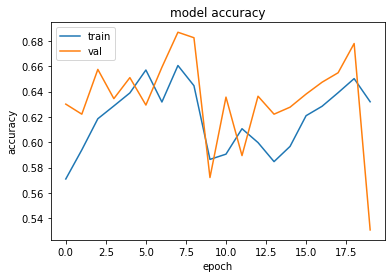

Saved model to disk
Test loss: 0.6846112473194416 / Test accuracy: 0.5571153846153846
Accuracy: 0.557115
Precision: 0.556318
Recall: 0.963300
F1 score: 0.705310


In [47]:
# Plot and save the performance history of the RNN model
performance_history(history, model_type, name)

# Store the RNN model and its weights
store_model(model_rnn, model_type, name)

# Evaluate the RNN model's performance on the test data and print the results
model_evaluation(model_rnn, test_text_padded, y_test)

# Generate a performance report for the RNN model and store it in a CSV file
performance_report(model_rnn, test_text_padded, y_test)


### Running GRU network

In [36]:
# Measure the time it takes to run the following code
%%time

# Define network parameters and a unique name for the GRU model
model_type = 'GRU'
name = "Model_" + str(epochs) + dash + str(batch_size) + dash + str(max_text_length) + dash + str(vocab_size) + dash

# Build a GRU model with the specified embedding layer
model_gru = build_network_GRU(embedding_layer)

# Train the GRU model with the training and test data, and obtain the training history
model_gru, history_gru = train_model(model_gru, train_text_padded, y_train, test_text_padded, y_test)


 Building GRU network 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          20148300  
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 20,211,865
Trainable params: 63,565
Non-trainable params: 20,148,300
____________________________________

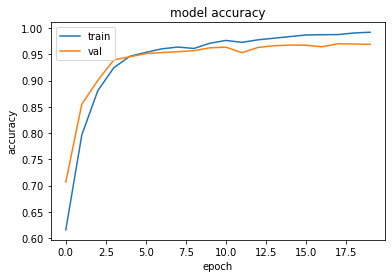

Saved model to disk
Test loss: 2.6609848763392523 / Test accuracy: 0.6434615384615384
Accuracy: 0.643462
Precision: 0.689928
Recall: 0.639287
F1 score: 0.663643


In [48]:
# Define the model type as 'GRU'
model_type = 'GRU'

# Plot and save the performance history of the GRU model
performance_history(history_gru, model_type, name)

# Store the GRU model and its weights
store_model(model_gru, model_type, name)

# Evaluate the GRU model's performance on the test data and print the results
model_evaluation(model_gru, test_text_padded, y_test)

# Generate a performance report for the GRU model and store it in a CSV file
performance_report(model_gru, test_text_padded, y_test)


### Running LSTM network

In [54]:
# Measure the time it takes to run the following code
%%time

# Define the model type as 'LSTM'
model_type = 'LSTM'

# Define a unique name for the LSTM model
name = "Model_" + str(epochs) + dash + str(batch_size) + dash + str(max_text_length) + dash + str(vocab_size) + dash

# Build an LSTM model with the specified embedding layer and LSTM size
model_lstm = build_network_lstm(embedding_layer, lstm_size)

# Train the LSTM model with the training and test data, and obtain the training history
model_lstm, history_lstm = train_model(model_lstm, train_text_padded, y_train, test_text_padded, y_test)


 Building Sequential network 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          20148300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 20,231,965
Trainable params: 83,665
Non-trainable params: 20,148,300
_____________________________

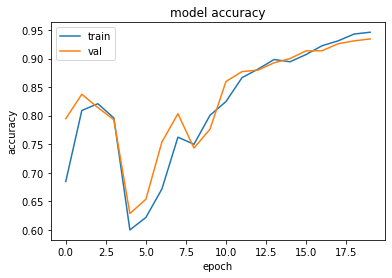

Saved model to disk
Test loss: 1.3714693516951342 / Test accuracy: 0.645
Accuracy: 0.645000
Precision: 0.690575
Recall: 0.642782
F1 score: 0.665822


In [50]:
# Plot and save the performance history of the LSTM model
performance_history(history_lstm, model_type, name)

# Store the LSTM model and its weights
store_model(model_lstm, model_type, name)

# Evaluate the LSTM model's performance on the test data and print the results
model_evaluation(model_lstm, test_text_padded, y_test)

# Generate a performance report for the LSTM model and store it in a CSV file
performance_report(model_lstm, test_text_padded, y_test)


---